In [9]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import hamming
import gudhi as gd
import seaborn as sns
from statistics import mode
import multiprocessing
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import gudhi as gd
from scipy.spatial.distance import hamming
import plotly.graph_objs as go
import networkx as nx
import plotly.graph_objects as go
import plotly.io as pio
from networkx.utils import not_implemented_for, pairwise
from concurrent.futures import ThreadPoolExecutor, as_completed

<h3>Dos funciones para obtener los data frames de presencia</h3>

In [98]:
def get_info_by_pathway_and_all_genomes_directions(info):
    data_frames={}
    pathways=set()
    directions={}
    genome_directions={}
    for i in range(info.shape[0]):
        #Revisar si se debe separar esto
        #pathway=info.loc[i,0].split('|')[0].strip('\ufeff')
        pathway=info.loc[i,0].split('|')[0]
        if pathway not in directions.keys():
            directions[pathway]=[i]
        else:
            directions[pathway].append(i)
        #Se cambia la primer columna, para tener los genes
        gen_with_number=info.loc[i,0].split('|')[2]
        gen=gen_with_number[0:gen_with_number.rfind('_')]
        info.loc[i,0]=gen
        #Se obtienen los genomas
        genome=info.loc[i,1].split('|')[2]
        if genome not in genome_directions.keys():
            genome_directions[genome]=[i]
        else:
            genome_directions[genome].append(i)

    
    for pathway in directions.keys():
        data_frames[pathway]=info.loc[directions[pathway],:]
    return data_frames,genome_directions

In [99]:
def get_df_by_pathway(info_by_pathway_and_genomes_directions):
    info_by_pathway=info_by_pathway_and_genomes_directions[0]
    genomes_directions=info_by_pathway_and_genomes_directions[1]
    df_by_pathway={}

    for path in info_by_pathway.keys():
        info_path=info_by_pathway[path]
        genes=set(info_by_pathway[path][0].values)
        df=pd.DataFrame(index=genomes_directions.keys(),columns=list(genes))
        df.index.name=path
        
        for gen in genes:
            info_path_and_gen=info_path[info_path[0]==gen]
            for genom in genomes_directions.keys():
                direction=set(genomes_directions[genom]) & set(info_path_and_gen.index) 
                genomes_per_gen=info_path_and_gen.loc[list(direction)]
                uniq_genomes_per_gen=genomes_per_gen[1].drop_duplicates()
                df.loc[genom,gen]=uniq_genomes_per_gen.shape[0]
        df_by_pathway[path]=df.sort_index()
    return df_by_pathway

In [40]:
def join_dfs(df_by_pathway):
    dfs=[]
    for key in df_by_pathway.keys():
        dfs.append(df_by_pathway[key])
    return pd.concat(dfs, axis=1)
    
    

<h3>Funciones para dar peso</h3>

In [4]:
def get_mode(df):
    arr=[]
    for i in df.values:
        for j in i:
            if j !=0:
                arr.append(j)
    return mode(arr)

In [5]:
def get_weights(presence):
    mode=get_mode(presence)
    #peso menor que moda
    piv=presence[presence<mode]
    presence[piv>0]=1
    #peso igual a moda
    presence[presence==mode]=2
    #peso mayor que moda
    presence[presence>mode]=3
    return presence

<h2>Funciones para crear matrices de distancia,los complejos simpliciales</h2>

In [145]:
# Let's assume that "population" is a numpy ndarray with your genomes as rows.
def calculate_hamming_matrix(population):
    # Number of genomes
    num_genomes = population.shape[0]
    # Create an empty matrix for Hamming distances
    hamming_matrix = np.zeros((num_genomes, num_genomes), dtype=float)
   # Calculate the Hamming distance between each pair of genomes
    size=num_genomes*(num_genomes-1)//2
    epsilon=0.0001
    increments=(np.random.RandomState(12).rand(size))*epsilon
    for i in range(num_genomes):
        for j in range(i+1, num_genomes):  # j=i+1 to avoid calculating the same distance twice
            # The Hamming distance is multiplied by the number of genes to convert it into an absolute distance
            #distance = hamming(population[i], population[j]) * len(population[i]) +increments[-1]
            distance = hamming(population[i], population[j]) * len(population[i])
            hamming_matrix[i, j] = distance
            hamming_matrix[j, i] = distance  # The matrix is symmetric
            increments=increments[:-1]
    return hamming_matrix

In [128]:
x=df_by_pathway['R5P_AMINOACIDS']
x

,imidazoleglycerol_phosphate_dehydratase,histidinol_dehydrogenase,ribosephosphate_pyrophosphokinase,imidazole_glycerol_phosphate_synthase_H,phosphoribosyl_isomerase_A
R5P_AMINOACIDS,,,,,
6666666.212053,2,1,0,1,1
6666666.212054,1,1,0,1,1
6666666.212055,1,1,1,2,1
6666666.212056,0,1,0,1,1
6666666.212058,1,1,1,2,2
...,...,...,...,...,...
6666666.212484,1,2,1,4,1
6666666.212485,1,1,1,4,1
6666666.212486,1,1,1,2,2


In [124]:
m=calculate_hamming_matrix(x.values)

In [125]:
simplicial_complex=create_complex(m)


<AxesSubplot:title={'center':'Persistence barcode'}>

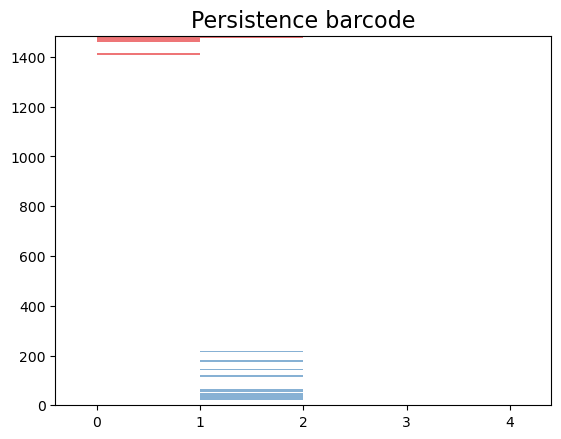

In [126]:
gd.plot_persistence_barcode(simplicial_complex[0])

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

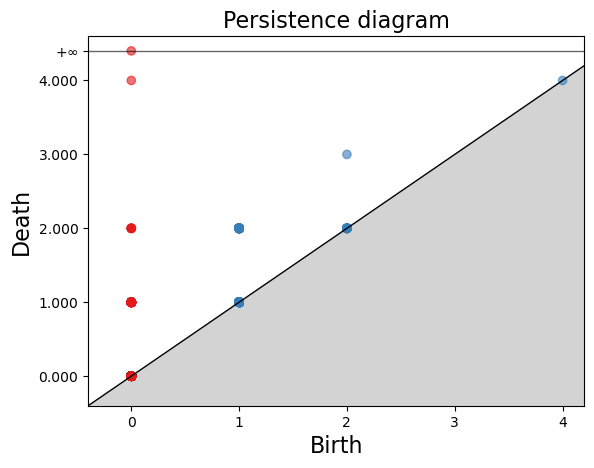

In [127]:
gd.plot_persistence_diagram(simplicial_complex[0])

In [116]:
x

,imidazoleglycerol_phosphate_dehydratase,histidinol_dehydrogenase,ribosephosphate_pyrophosphokinase,imidazole_glycerol_phosphate_synthase_H,phosphoribosyl_isomerase_A
R5P_AMINOACIDS,,,,,
6666666.212053,2,1,0,1,1
6666666.212054,1,1,0,1,1
6666666.212055,1,1,1,2,1
6666666.212056,0,1,0,1,1
6666666.212058,1,1,1,2,2
...,...,...,...,...,...
6666666.212484,1,2,1,4,1
6666666.212485,1,1,1,4,1
6666666.212486,1,1,1,2,2


In [ ]:
def plot_all_heatmap(complex_pathways):
    for i in complex_pathways.keys():
        gd.plot_persistence_barcode(complex_pathways[i][0],legend=True)
        plt.title(f"{i}" )

In [138]:
def create_complex(distance_matrix2):
    # Create the Rips simplicial complex from the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distance_matrix2)
    # Create the simplex tree from the Rips complex with a maximum dimension of 3
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    # Compute the persistence of the simplicial complex
    persistence = simplex_tree.persistence()
    # Return the persistence diagram or barcode
    return persistence, simplex_tree


In [139]:
def get_complex_by_pathways(path_dict):
    complex_path_dict={}
    for path in path_dict.keys():
        complex_path_dict[path]=create_complex(calculate_hamming_matrix(path_dict[path].values))
    return complex_path_dict

In [140]:
def plot_all_bar_code_pathways(complex_pathways):
    for i in complex_pathways.keys():
        gd.plot_persistence_barcode(complex_pathways[i][0],legend=True)
        gd.plot_persistence_diagram(complex_pathways[i][0],legend=True)
        plt.title(f"{i}" )

<h2>Funciones para obtener los uno-hoyos</h2>

In [10]:
def dict_holes_to_names(holes):
    key=list(df_by_pathway.keys())[0]
    df=df_by_pathway[key].copy(deep=True)
    df.reset_index(inplace=True)
    true_name_holes=[]
    for hole in holes:
        true_name_holes.append(list(df.loc[hole,:]['index']))
    return true_name_holes

In [93]:
def minimum_cycle_basis(G, weight=None, total=None):
    """Returns a minimum weight cycle basis for G

    Minimum weight means a cycle basis for which the total weight
    (length for unweighted graphs) of all the cycles is minimum.

    Parameters
    ----------
    G : NetworkX Graph
    weight: string
        name of the edge attribute to use for edge weights

    Returns
    -------
    A list of cycle lists.  Each cycle list is a list of nodes
    which forms a cycle (loop) in G. Note that the nodes are not
    necessarily returned in a order by which they appear in the cycle

    Examples
    --------
    >>> G = nx.Graph()
    >>> nx.add_cycle(G, [0, 1, 2, 3])
    >>> nx.add_cycle(G, [0, 3, 4, 5])
    >>> nx.minimum_cycle_basis(G)
    [[5, 4, 3, 0], [3, 2, 1, 0]]

    References:
        [1] Kavitha, Telikepalli, et al. "An O(m^2n) Algorithm for
        Minimum Cycle Basis of Graphs."
        http://link.springer.com/article/10.1007/s00453-007-9064-z
        [2] de Pina, J. 1995. Applications of shortest path methods.
        Ph.D. thesis, University of Amsterdam, Netherlands

    See Also
    --------
    simple_cycles, cycle_basis
    """
    # We first split the graph in connected subgraphs
    return sum(
        (_min_cycle_basis(G.subgraph(c), weight,total) for c in nx.connected_components(G)),
        [],
    )

def _min_cycle_basis(G, weight,total):
    cb = []
    cont=0
    # We  extract the edges not in a spanning tree. We do not really need a
    # *minimum* spanning tree. That is why we call the next function with
    # weight=None. Depending on implementation, it may be faster as well
    tree_edges = list(nx.minimum_spanning_edges(G, weight=None, data=False))
    chords = G.edges - tree_edges - {(v, u) for u, v in tree_edges}

    # We maintain a set of vectors orthogonal to sofar found cycles
    set_orth = [{edge} for edge in chords]
    while set_orth:
        if cont==total:
            break
        base = set_orth.pop()
        # kth cycle is "parallel" to kth vector in set_orth
        cycle_edges = _min_cycle(G, base, weight)
        cycle_found=[v for u, v in cycle_edges]

        if len(cycle_found)>3:
            cb.append(cycle_found)
            cont+=1

        # now update set_orth so that k+1,k+2... th elements are
        # orthogonal to the newly found cycle, as per [p. 336, 1]
        set_orth = [
            (
                {e for e in orth if e not in base if e[::-1] not in base}
                | {e for e in base if e not in orth if e[::-1] not in orth}
            )
            if sum((e in orth or e[::-1] in orth) for e in cycle_edges) % 2
            else orth
            for orth in set_orth
        ]
    return cb


def _min_cycle(G, orth, weight):
    """
    Computes the minimum weight cycle in G,
    orthogonal to the vector orth as per [p. 338, 1]
    Use (u, 1) to indicate the lifted copy of u (denoted u' in paper).
    """
    Gi = nx.Graph()

    # Add 2 copies of each edge in G to Gi.
    # If edge is in orth, add cross edge; otherwise in-plane edge
    for u, v, wt in G.edges(data=weight, default=1):
        if (u, v) in orth or (v, u) in orth:
            Gi.add_edges_from([(u, (v, 1)), ((u, 1), v)], Gi_weight=wt)
        else:
            Gi.add_edges_from([(u, v), ((u, 1), (v, 1))], Gi_weight=wt)

    # find the shortest length in Gi between n and (n, 1) for each n
    # Note: Use "Gi_weight" for name of weight attribute
    spl = nx.shortest_path_length
    lift = {n: spl(Gi, source=n, target=(n, 1), weight="Gi_weight") for n in G}

    # Now compute that short path in Gi, which translates to a cycle in G
    start = min(lift, key=lift.get)
    end = (start, 1)
    min_path_i = nx.shortest_path(Gi, source=start, target=end, weight="Gi_weight")

    # Now we obtain the actual path, re-map nodes in Gi to those in G
    min_path = [n if n in G else n[0] for n in min_path_i]

    # Now remove the edges that occur two times
    # two passes: flag which edges get kept, then build it
    edgelist = list(pairwise(min_path))
    edgeset = set()
    for e in edgelist:
        if e in edgeset:
            edgeset.remove(e)
        elif e[::-1] in edgeset:
            edgeset.remove(e[::-1])
        else:
            edgeset.add(e)

    min_edgelist = []
    for e in edgelist:
        if e in edgeset:
            min_edgelist.append(e)
            edgeset.remove(e)
        elif e[::-1] in edgeset:
            min_edgelist.append(e[::-1])
            edgeset.remove(e[::-1])

    return min_edgelist

In [150]:
def find_all_cycles(complex_path):
    persistence,simplex_tree=complex_pathways[complex_path]
    born_and_number = born_filtraton_value_holes(persistence)
    G=nx.Graph()
    born=born_and_number.keys()
    ciclos_dep=set()
    filtration=0
    for simplex, filt in simplex_tree.get_filtration():
        #if len(ciclos_dep)==num_holes:
         #   break
        
        if filtration!=filt and filtration in born:
            number=born_and_number[filtration]
            print('se buscan ciclos en el tiempo', filt,'para',complex_path)
            ciclos=minimum_cycle_basis(G,total=number)
            for ciclo in ciclos:
                if len(ciclo)>3:
                    print('Se encontró el ciclo',ciclo,'en el tiempo', filtration,'para',complex_path)
                    ciclos_dep.add(tuple(ciclo))
                    #Se llena el hoyo
                    for i in ciclo:
                        for j in ciclo:
                            G.add_edge(i,j)
                            
            
        filtration=filt
        
        if len(simplex)==2:
            G.add_edge(simplex[0], simplex[1])


    #direc='pseudomonas_'+complex_path+'.txt'
    #f = open(direc, "a")
    #f.write(str(ciclos_dep))
    #f.close()
        

    return [complex_path,dict_holes_to_names(ciclos_dep)]

In [95]:
def find_all_cycles_whitout_dict(complex_path):
    persistence,simplex_tree=complex_path
    born_and_number = born_filtraton_value_holes(persistence)
    G=nx.Graph()
    born=born_and_number.keys()
    ciclos_dep=set()
    filtration=0
    for simplex, filt in simplex_tree.get_filtration():
        #if len(ciclos_dep)==num_holes:
         #   break
        
        if filtration!=filt and filtration in born:
            number=born_and_number[filtration]
            print('se buscan ciclos en el tiempo', filt,'para')
            ciclos=minimum_cycle_basis(G,total=number)
            for ciclo in ciclos:
                if len(ciclo)>3:
                    print('Se encontró el ciclo',ciclo,'en el tiempo', filtration,'para')
                    ciclos_dep.add(tuple(ciclo))
                    #Se llena el hoyo
                    for i in ciclo:
                        for j in ciclo:
                            G.add_edge(i,j)
                            
            
        filtration=filt
        
        if len(simplex)==2:
            G.add_edge(simplex[0], simplex[1])


    #direc='pseudomonas_'+complex_path+'.txt'
    #f = open(direc, "a")
    #f.write(str(ciclos_dep))
    #f.close()
        

    return ciclos_dep

In [89]:
def born_filtraton_value_holes(persistence):
    born=[]
    for bar in persistence:
        if bar[0]==1:
            born.append(bar[1][0])
            
    born_and_number=set([(x,born.count(x)) for x  in born])

    return dict(born_and_number)

In [90]:
def get_holes_by_pathways(complex_by_path):
    llaves=complex_by_path.keys()
    with multiprocessing.Pool() as pool:
        # Mapear los ítems a la función process_item en paralelo
        results = pool.map(find_all_cycles,llaves)
    return dict(results)

In [91]:
def get_dict_names(names):
    dict_code_and_name={}
    for i in names.index:
        dict_code_and_name[names.loc[i,1]]=names.loc[i,2]
    return dict_code_and_name

In [16]:
def change_codes_to_names(codes,dict_code_and_name):
    names=[]
    for code in codes:
        name_per_element=[]
        for element in code:
            name_per_element.append(dict_code_and_name[element])
        names.append(name_per_element)
    return names

In [17]:
def get_hole_names_by_pathway(holes_by_pathway,dict_code_and_name):
    hole_names_by_pathway={}
    for path in holes_by_pathway.keys():
        hole_names_by_pathway[path]=change_codes_to_names(holes_by_pathway[path],dict_code_and_name)
    return hole_names_by_pathway

<h2>EJECUCIÓN:Se pide un score minimo</h2>

In [146]:
info=pd.read_csv('data/pscpOrinth.blast',sep='\t',header=None)
minimum_score=100
info=info[info[11]>=minimum_score]
info.reset_index(drop=True,inplace=True)
info=info.loc[:,0:1]


In [147]:
info_by_pathway_and_genomes_directions=get_info_by_pathway_and_all_genomes_directions(info)
df_by_pathway=get_df_by_pathway(info_by_pathway_and_genomes_directions)
complex_pathways=get_complex_by_pathways(df_by_pathway)

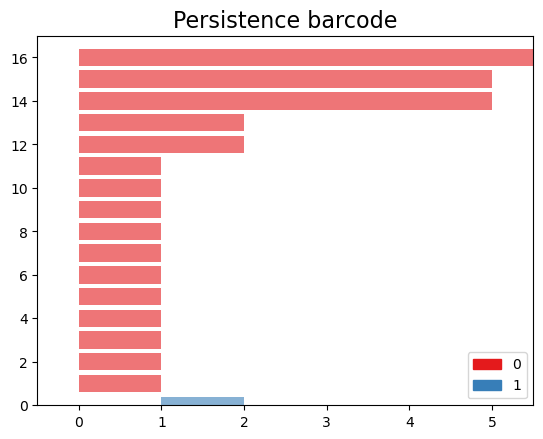

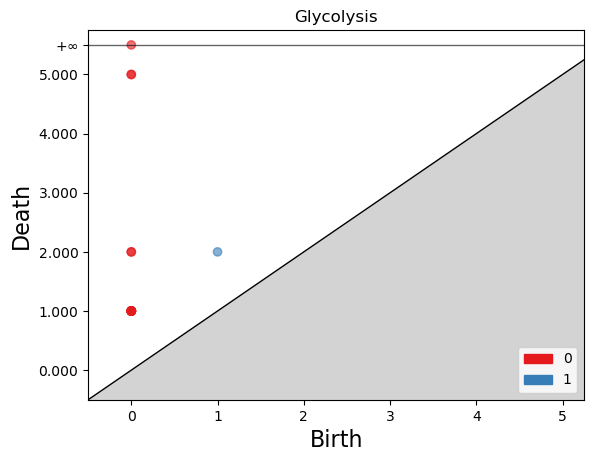

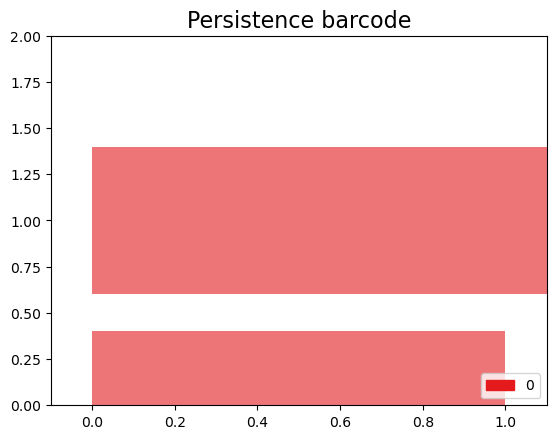

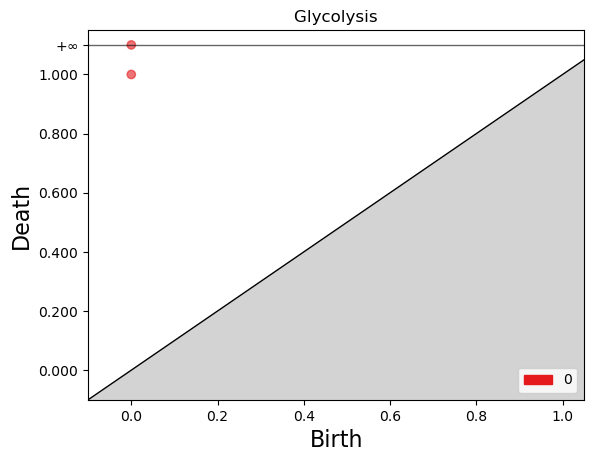

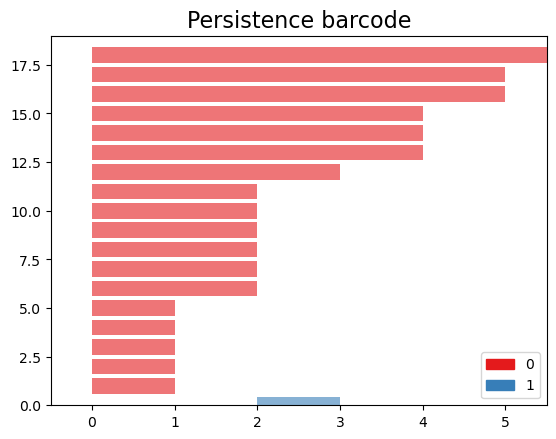

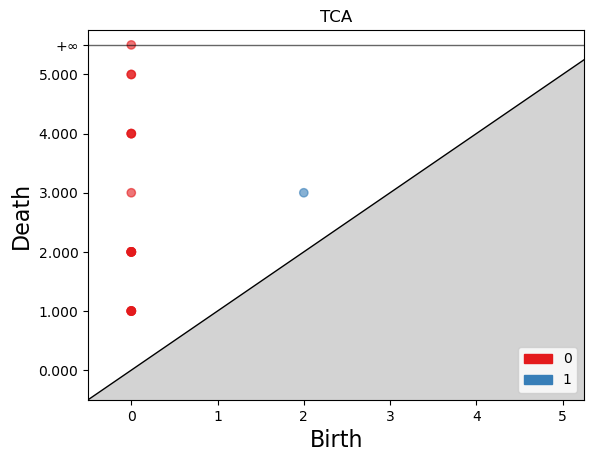

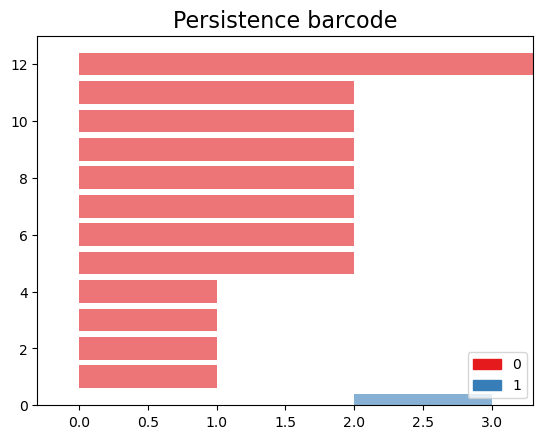

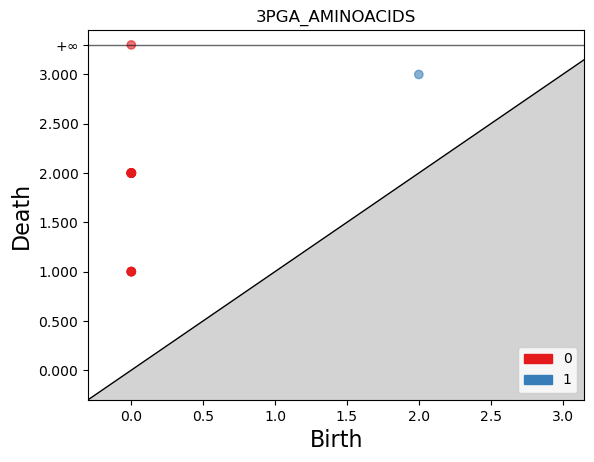

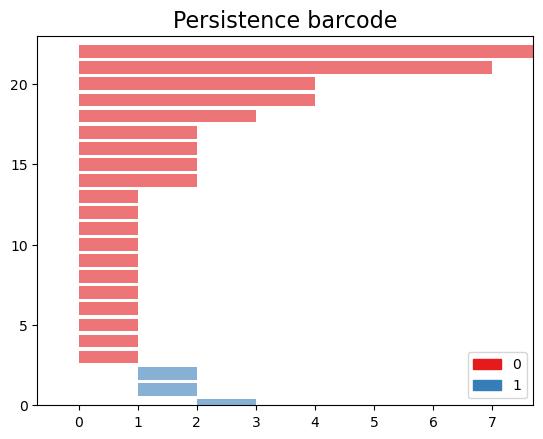

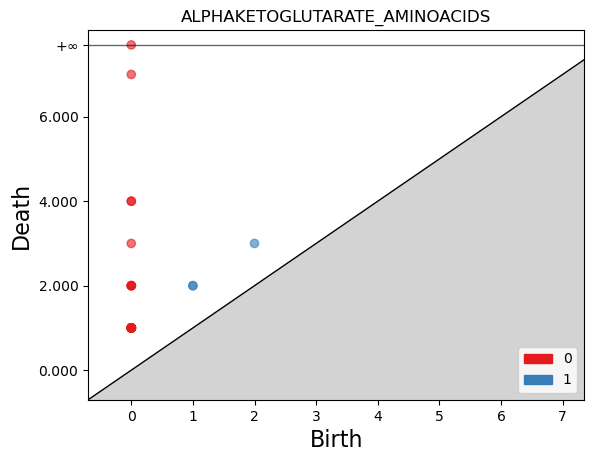

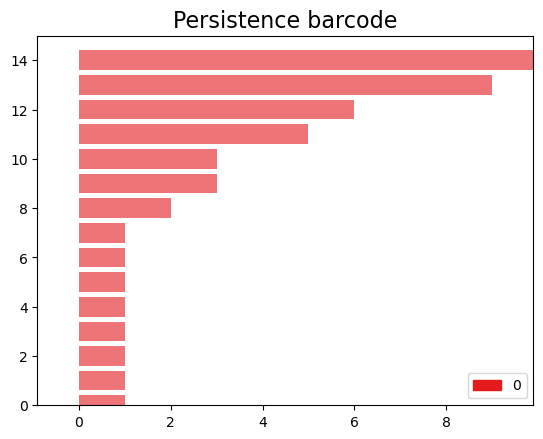

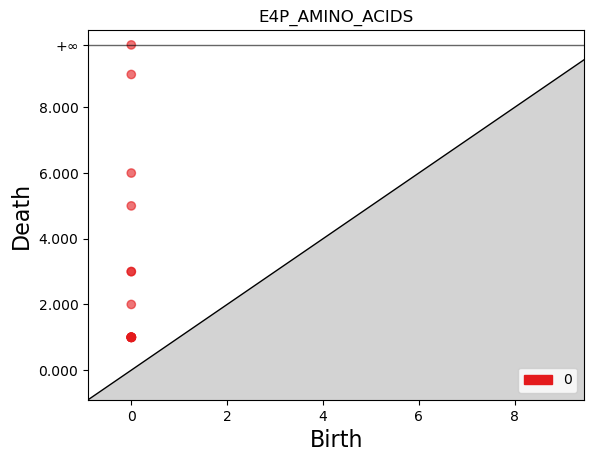

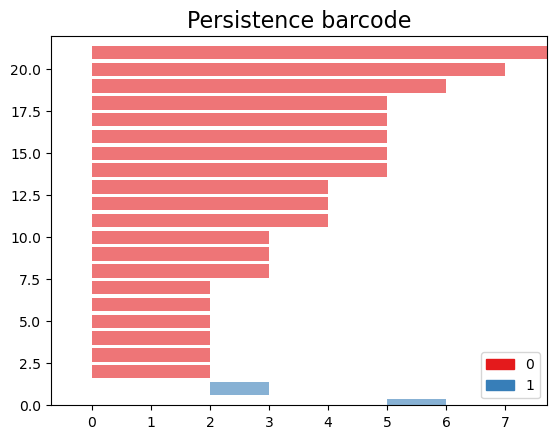

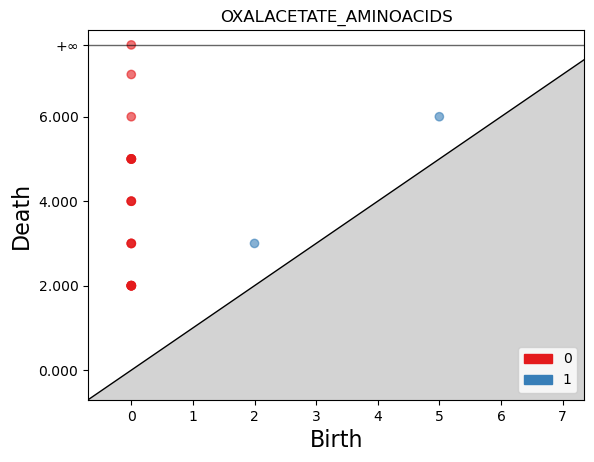

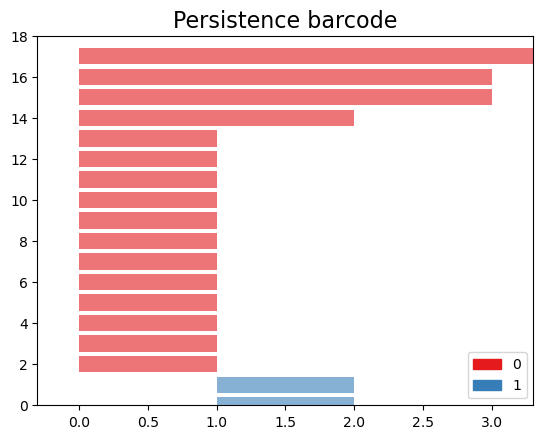

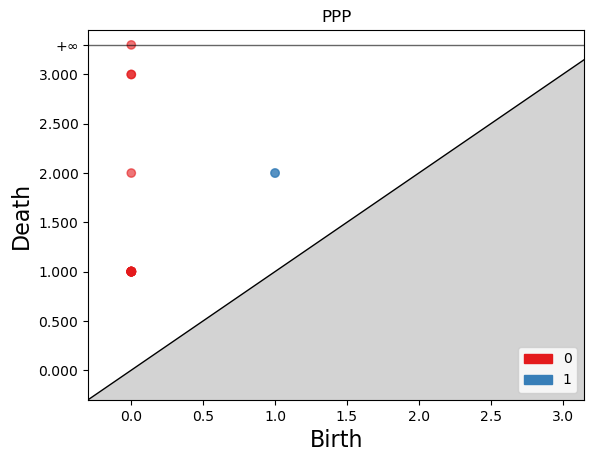

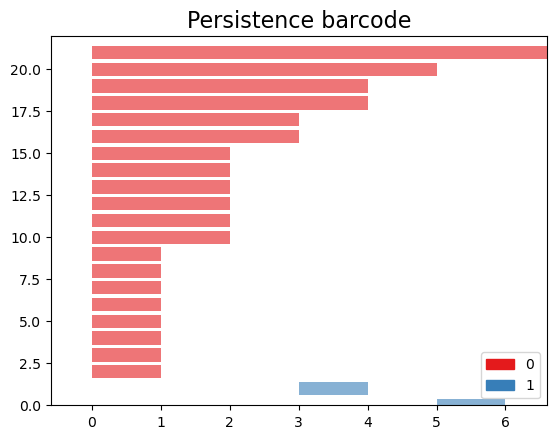

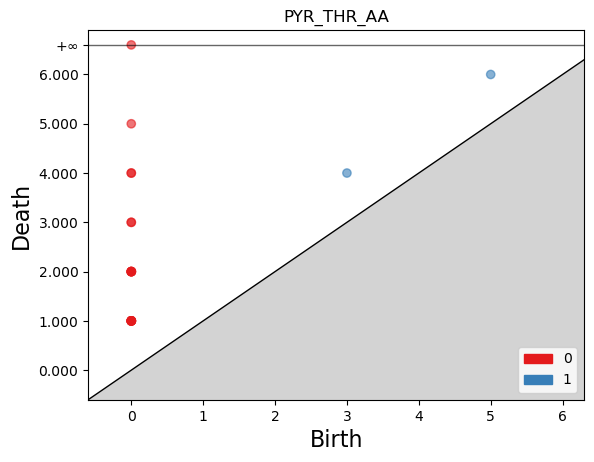

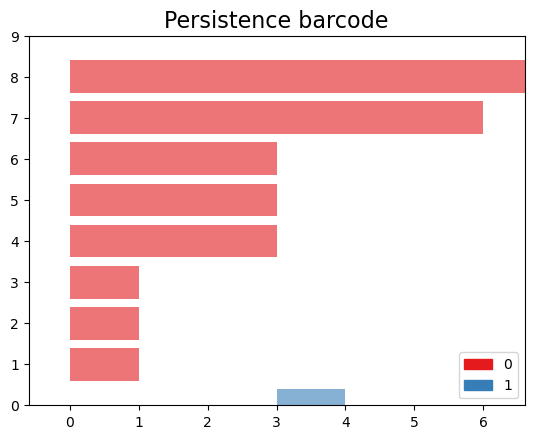

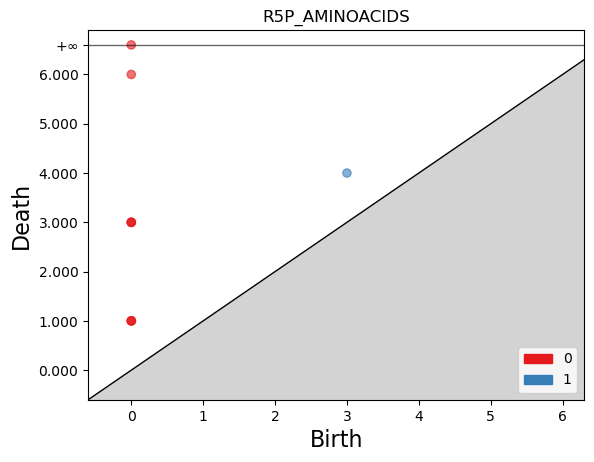

In [148]:
plot_all_bar_code_pathways(complex_pathways)

In [151]:
ciclos=get_holes_by_pathways(complex_pathways)

se buscan ciclos en el tiempose buscan ciclos en el tiempose buscan ciclos en el tiempose buscan ciclos en el tiempo    3.02.03.02.0   para parapara para 3PGA_AMINOACIDS  Glycolysis
TCA
ALPHAKETOGLUTARATE_AMINOACIDS

se buscan ciclos en el tiempo 2.0se buscan ciclos en el tiempo para  3.0se buscan ciclos en el tiempoPPP se buscan ciclos en el tiempo
para   4.0OXALACETATE_AMINOACIDS4.0 
 paraSe encontró el ciclo para PYR_THR_AA [20, 14, 10, 5]
R5P_AMINOACIDS 
en el tiempoSe encontró el ciclo  1.0[9, 6, 1, 0]  paraen el tiempo  Se encontró el cicloALPHAKETOGLUTARATE_AMINOACIDS2.0 
 [6, 5, 4, 3, 2, 15, 7]Se encontró el ciclo paraen el tiempo  [20, 8, 6, 5] OXALACETATE_AMINOACIDS 1.0
en el tiempo  se buscan ciclos en el tiempo1.0para   6.0paraGlycolysis  paraALPHAKETOGLUTARATE_AMINOACIDS

 OXALACETATE_AMINOACIDSse buscan ciclos en el tiempo
 3.0 para ALPHAKETOGLUTARATE_AMINOACIDS
Se encontró el ciclo [1, 7, 16, 0] en el tiempo 2.0 para TCA
Se encontró el ciclo [18, 3, 6, 0] en el tiempo 5.

NameError: name 'dict_holes_to_names' is not defined

In [54]:
join_df=join_dfs(df_by_pathway)

In [67]:
join_df_drop=join_df.drop_duplicates(keep=False)
join_df_drop.shape

(331, 44)

In [56]:
join_df.shape

(416, 44)

In [46]:
join_complex=create_complex(calculate_hamming_matrix(join_df.values))

In [68]:
join_drop_complex=create_complex(calculate_hamming_matrix(join_df_drop.values))

In [95]:
join_complex

(10, 3)

<AxesSubplot:title={'center':'Persistence barcode'}>

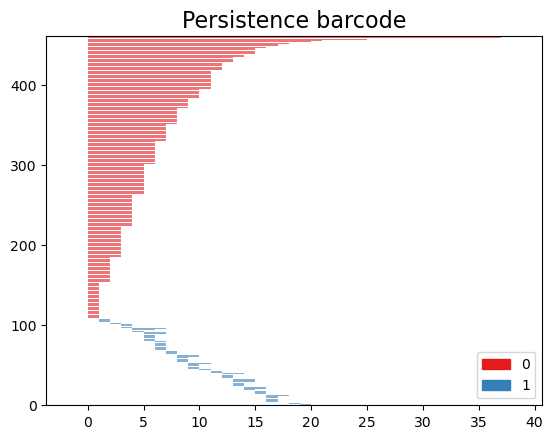

In [71]:
gd.plot_persistence_barcode(join_complex[0],legend='Unidos con repeticiones')

<AxesSubplot:title={'center':'Persistence barcode'}>

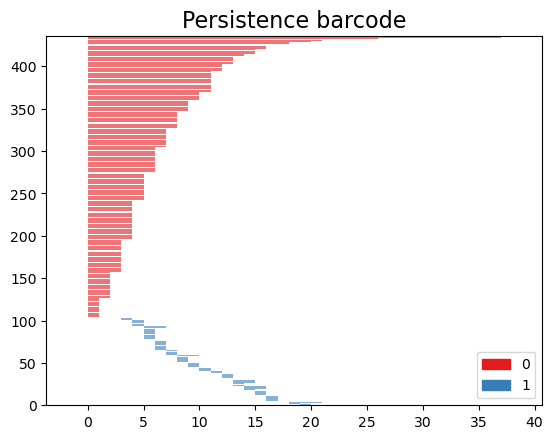

In [73]:
gd.plot_persistence_barcode(join_drop_complex[0],legend='Unidos sin repeticiones')

In [96]:
for key in df_by_pathway.keys():
    objec=df_by_pathway[key].copy()
    s=objec.drop_duplicates(inplace=False)
    print(df_by_pathway[key].shape[1],s.shape[1],key)


1 1 calcium-dependent-antibiotic
1 1 polyketide
2 2 3PGA_AMINOACIDS
12 12 ALPHAKETOGLUTARATE_AMINOACIDS
7 7 E4P_AMINO_ACIDS
3 3 Glycolysis
5 5 OXALACETATE_AMINOACIDS
6 6 PYR_THR_AA
5 5 R5P_AMINOACIDS
3 3 TCA


In [68]:
complex_pathways['Glycolysis'][1].persistence()

[(1, (1.0, 2.0)),
 (1, (1.0, 2.0)),
 (0, (0.0, inf)),
 (0, (0.0, 2.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0))]

In [64]:
cont=0
vertices=[]
for i in complex_pathways['Glycolysis'][1].get_filtration():
    if i[0]==[0,1]:
        vertices.append(i)

In [65]:
vertices

[([0, 1], 0.0)]

In [48]:
prueba=df_by_pathway['Glycolysis'].drop_duplicates()

In [50]:
p=create_complex(calculate_hamming_matrix(prueba.values))

In [58]:
find_all_cycles(complex_pathways['Glycolysis'])

se buscan ciclos en el tiempo 2.0 para ([(1, (1.0, 2.0)), (1, (1.0, 2.0)), (0, (0.0, inf)), (0, (0.0, 2.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0))], <gudhi.simplex_tree.SimplexTree object at 0x70b02e9f37b0>)
[201, 205, 0]
[178, 114, 0]
[113, 91, 0]
[158, 182, 0]
[105, 188, 0]
[125, 30, 0]
[67, 107, 0]
[6, 107, 0]
[76, 20, 0]
[11, 178, 0]
[101, 214, 0]
[10, 151, 0]
[152, 205, 0]
[78, 79, 0]
[129, 178, 0]
[136, 92, 0]
[1, 79, 0]
[128, 199, 0]
[120, 210, 0]
[44, 148, 0]
[79, 156, 0]
[25, 39, 0]
[1, 173, 0]
[106, 92, 0]
[31, 136, 0]
[106, 203, 0]
[82, 193, 0]
[159, 150, 0]
[36, 131, 0]
[126, 191, 0]
[154, 163, 0]
[26, 118, 0]
[79, 126, 0]
[3, 205, 0]
[2, 124, 0]
[132, 70, 0]
[69, 163, 0]
[121, 195, 0]
[161, 23, 0]
[97, 201, 0]
[22, 136, 0]
[74, 120, 0]
[215, 73, 0]
[133, 88, 0]


KeyboardInterrupt: 

In [56]:
def find_all_cycles(complex_path):
    persistence,simplex_tree=complex_path
    born_and_number = born_filtraton_value_holes(persistence)
    G=nx.Graph()
    born=born_and_number.keys()
    ciclos_dep=set()
    filtration=0
    for simplex, filt in simplex_tree.get_filtration():
        #if len(ciclos_dep)==num_holes:
         #   break
        
        if filtration!=filt and filtration in born:
            number=born_and_number[filtration]
            print('se buscan ciclos en el tiempo', filt,'para',complex_path)
            ciclos=minimum_cycle_basis(G,total=number)
            for ciclo in ciclos:
                if len(ciclo)>3:
                    print('Se encontró el ciclo',ciclo,'en el tiempo', filtration,'para',complex_path)
                    ciclos_dep.add(tuple(ciclo))
                    #Se llena el hoyo
                    for i in ciclo:
                        for j in ciclo:
                            G.add_edge(i,j)
                            
            
        filtration=filt
        
        if len(simplex)==2:
            G.add_edge(simplex[0], simplex[1])


    #direc='pseudomonas_'+complex_path+'.txt'
    #f = open(direc, "a")
    #f.write(str(ciclos_dep))
    #f.close()
        

    return ciclos_dep

In [57]:
def minimum_cycle_basis(G, weight=None, total=None):
    """Returns a minimum weight cycle basis for G

    Minimum weight means a cycle basis for which the total weight
    (length for unweighted graphs) of all the cycles is minimum.

    Parameters
    ----------
    G : NetworkX Graph
    weight: string
        name of the edge attribute to use for edge weights

    Returns
    -------
    A list of cycle lists.  Each cycle list is a list of nodes
    which forms a cycle (loop) in G. Note that the nodes are not
    necessarily returned in a order by which they appear in the cycle

    Examples
    --------
    >>> G = nx.Graph()
    >>> nx.add_cycle(G, [0, 1, 2, 3])
    >>> nx.add_cycle(G, [0, 3, 4, 5])
    >>> nx.minimum_cycle_basis(G)
    [[5, 4, 3, 0], [3, 2, 1, 0]]

    References:
        [1] Kavitha, Telikepalli, et al. "An O(m^2n) Algorithm for
        Minimum Cycle Basis of Graphs."
        http://link.springer.com/article/10.1007/s00453-007-9064-z
        [2] de Pina, J. 1995. Applications of shortest path methods.
        Ph.D. thesis, University of Amsterdam, Netherlands

    See Also
    --------
    simple_cycles, cycle_basis
    """
    # We first split the graph in connected subgraphs
    return sum(
        (_min_cycle_basis(G.subgraph(c), weight,total) for c in nx.connected_components(G)),
        [],
    )

def _min_cycle_basis(G, weight,total):
    cb = []
    cont=0
    # We  extract the edges not in a spanning tree. We do not really need a
    # *minimum* spanning tree. That is why we call the next function with
    # weight=None. Depending on implementation, it may be faster as well
    tree_edges = list(nx.minimum_spanning_edges(G, weight=None, data=False))
    chords = G.edges - tree_edges - {(v, u) for u, v in tree_edges}

    # We maintain a set of vectors orthogonal to sofar found cycles
    set_orth = [{edge} for edge in chords]
    while set_orth:
        if cont==total:
            break
        base = set_orth.pop()
        # kth cycle is "parallel" to kth vector in set_orth
        cycle_edges = _min_cycle(G, base, weight)
        cycle_found=[v for u, v in cycle_edges]
        print(cycle_found)
        if len(cycle_found)>3:
            cb.append(cycle_found)
            cont+=1

        # now update set_orth so that k+1,k+2... th elements are
        # orthogonal to the newly found cycle, as per [p. 336, 1]
        set_orth = [
            (
                {e for e in orth if e not in base if e[::-1] not in base}
                | {e for e in base if e not in orth if e[::-1] not in orth}
            )
            if sum((e in orth or e[::-1] in orth) for e in cycle_edges) % 2
            else orth
            for orth in set_orth
        ]
    return cb


def _min_cycle(G, orth, weight):
    """
    Computes the minimum weight cycle in G,
    orthogonal to the vector orth as per [p. 338, 1]
    Use (u, 1) to indicate the lifted copy of u (denoted u' in paper).
    """
    Gi = nx.Graph()

    # Add 2 copies of each edge in G to Gi.
    # If edge is in orth, add cross edge; otherwise in-plane edge
    for u, v, wt in G.edges(data=weight, default=1):
        if (u, v) in orth or (v, u) in orth:
            Gi.add_edges_from([(u, (v, 1)), ((u, 1), v)], Gi_weight=wt)
        else:
            Gi.add_edges_from([(u, v), ((u, 1), (v, 1))], Gi_weight=wt)

    # find the shortest length in Gi between n and (n, 1) for each n
    # Note: Use "Gi_weight" for name of weight attribute
    spl = nx.shortest_path_length
    lift = {n: spl(Gi, source=n, target=(n, 1), weight="Gi_weight") for n in G}

    # Now compute that short path in Gi, which translates to a cycle in G
    start = min(lift, key=lift.get)
    end = (start, 1)
    min_path_i = nx.shortest_path(Gi, source=start, target=end, weight="Gi_weight")

    # Now we obtain the actual path, re-map nodes in Gi to those in G
    min_path = [n if n in G else n[0] for n in min_path_i]

    # Now remove the edges that occur two times
    # two passes: flag which edges get kept, then build it
    edgelist = list(pairwise(min_path))
    edgeset = set()
    for e in edgelist:
        if e in edgeset:
            edgeset.remove(e)
        elif e[::-1] in edgeset:
            edgeset.remove(e[::-1])
        else:
            edgeset.add(e)

    min_edgelist = []
    for e in edgelist:
        if e in edgeset:
            min_edgelist.append(e)
            edgeset.remove(e)
        elif e[::-1] in edgeset:
            min_edgelist.append(e[::-1])
            edgeset.remove(e[::-1])

    return min_edgelist

In [95]:
names=pd.read_csv('data/Pseudomonas.ids',sep='\t',header=None,dtype='object')
dict_names=get_dict_names(names)
hole_names_by_pathway=get_hole_names_by_pathway(holes,dict_names)


[['666666.100019', '666666.100028', '666666.100027', '666666.100006'],
 ['666666.100023', '666666.100031', '666666.100007', '666666.100004'],
 ['666666.100023', '666666.100030', '666666.100006', '666666.100004']]

In [99]:
df_by_pathway['TCA'].to_csv('TCA.csv')

In [91]:
df_by_pathway['Glycolysis'].index.name='G'
df_by_pathway['Glycolysis']

,glyceraldehyde3phosphate_dehydrogenase,Fructose_biphosphate_aldolase,Glucose_kinase,Triosephosphate_isomerase,phosphoglycerate_kinase,phosphoglycerate_mutase,Phosphofructokinase,Glucose_6_phosphate_isomerase,Pyruvate_kinase,enolase
G,,,,,,,,,,
666666.100004,1,1,4,1,2,5,1,0,1,1
666666.100005,1,1,5,1,2,4,1,0,1,1
666666.100006,1,1,4,1,2,3,1,0,1,1
666666.100007,1,1,4,1,2,4,1,0,1,1
666666.100008,1,1,3,1,2,5,1,0,1,1
666666.100010,1,1,4,1,2,4,2,0,1,1
666666.100019,1,1,6,1,2,3,2,0,1,1
666666.100020,1,1,8,1,2,4,2,0,1,1
666666.100023,1,1,6,1,2,5,3,0,1,1
